<a href="https://colab.research.google.com/github/ferjjp/tp-iaa-clasificacion-de-manos/blob/main/Copia_de_TP_IAA_Reconocimiento_de_gestos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparar ambiente

In [5]:
#@title Instalar Auto-Keras 
#!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install keras-tuner --upgrade
!pip install autokeras

In [6]:
#@title Librerías a usar
%tensorflow_version 2.x
import autokeras as ak

from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

print("Setupeando TPU")
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Librerías cargadas
Setupeando TPU
Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [7]:
## selección de los parámetros 

#@markdown ### Parámetros de imágenes:
imagen_largo = 50 #@param {type:"integer"}
imagen_ancho = 50 #@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}
imagen_usar_generadas_data_augmentation = False #@param {type:"boolean"}

## aplicación de los parámetros elegidos

# tamaño de las imágenes
IMAGE_SHAPE = (imagen_largo, imagen_ancho, (3 if imagen_color else 1))

# indica si se usan las imágenes generadas por data augmentation
usarDA = imagen_usar_generadas_data_augmentation

# define tamaño de datos de entrada 
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]
print ("Tamaño datos de entrada: ", num_inputs)
print ("Tamaño Imagen: ", IMAGE_SHAPE)

Tamaño datos de entrada:  7500
Tamaño Imagen:  (50, 50, 3)


In [8]:
#@title Donde estan las imagenes?

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA_TP/Fotos/fase2_fer/' #@param {type:"string"}
path_entrenamiento = '/Entrenamiento'  #@param {type:"string"}
path_prueba = '/Pruebas'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


In [14]:
#@title: Definicion del dataset
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
   imagPath_train,
   validation_split=0.2,
  #  label_mode='categorical',
   subset="training",
   seed=123,
   image_size=(imagen_largo, imagen_ancho),
   batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   imagPath_train,
   validation_split=0.2,
  #  label_mode='categorical',
   subset="validation",
   seed=123,
   image_size=(imagen_largo, imagen_ancho),
   batch_size=batch_size
)


class_names = train_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
def preprocess(ds):
  return ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = preprocess(train_ds) #prefetch ciertas imagenes
val_ds = preprocess(val_ds)

Found 392 files belonging to 5 classes.
Using 314 files for training.
Found 392 files belonging to 5 classes.
Using 78 files for validation.


In [17]:
#@title Definicion de modelo

tipo_modelo_usar = "ImageClassifier" #@param ["ImageClassifier", "Personalizado"]

cantidad_intentos_encontrar_modelo =  10#@param {type:"integer"}
if cantidad_intentos_encontrar_modelo < 1:
  cantidad_intentos_encontrar_modelo = 1

max_cant_params_modelo =  5000000#@param {type:"integer"}
if max_cant_params_modelo <= 0:
  max_cant_params_modelo = None

max_epocas_entrenamiento =  300#@param {type:"integer"}
if max_epocas_entrenamiento <= 0:
  max_epocas_entrenamiento = None

with strategy.scope():
  if tipo_modelo_usar == "ImageClassifier":
      # Initialize the image classifier.
      AKmodel = ak.ImageClassifier( 
          num_classes=len(class_names), 
          overwrite=True,
          seed=1,
          objective='val_accuracy',
          # max_model_size=max_cant_params_modelo,
          max_trials=cantidad_intentos_encontrar_modelo)
  else:
      # capa de entrada
      input_node = ak.ImageInput()
      # capas intermedias
      output_node = ak.ImageBlock(
          # Only search ConvNet architectures.
          block_type="vanilla",
          # Normalize the dataset.
          normalize=True,
          # Allow do data augmentation.
          augment=False,
      )(input_node)
      # capa de salida
      # 
      output_node = ak.ClassificationHead(num_classes=len(class_names))(output_node)
      # Initialize AutoModel personalizado
      AKmodel = ak.AutoModel(
          inputs=input_node, outputs=output_node,          
          overwrite=True, 
          seed=1,
          objective='val_accuracy',
          max_model_size=max_cant_params_modelo,
          max_trials=cantidad_intentos_encontrar_modelo)

print("Modelo preparado")

Modelo preparado


In [18]:
#@title Entrenar con AutoKeras

# el history sólo devuelve el del último trial
history = AKmodel.fit(train_ds,
            epochs=max_epocas_entrenamiento,
            verbose=1,
            validation_data=val_ds)

print("\n>Entrenamiento Finalizado.")

Trial 10 Complete [00h 10m 48s]
val_accuracy: 0.8717948794364929

Best val_accuracy So Far: 0.9871794581413269
Total elapsed time: 02h 07m 58s
INFO:tensorflow:Oracle triggered exit
Epoch 1/300
20/20 [==============================] - 52s 1s/step - loss: 1.5497 - accuracy: 0.3089 - val_loss: 1.6971 - val_accuracy: 0.1923
Epoch 2/300
20/20 [==============================] - 19s 971ms/step - loss: 1.0854 - accuracy: 0.8185 - val_loss: 1.7128 - val_accuracy: 0.1923
Epoch 3/300
20/20 [==============================] - 19s 957ms/step - loss: 0.7987 - accuracy: 0.9650 - val_loss: 1.7346 - val_accuracy: 0.1923
Epoch 4/300
20/20 [==============================] - 19s 951ms/step - loss: 0.5871 - accuracy: 0.9745 - val_loss: 1.7298 - val_accuracy: 0.1923
Epoch 5/300
20/20 [==============================] - 19s 957ms/step - loss: 0.4308 - accuracy: 0.9841 - val_loss: 1.6770 - val_accuracy: 0.1923
Epoch 6/300
20/20 [==============================] - 19s 956ms/step - loss: 0.2869 - accuracy: 1.0000 

In [19]:
#@title Armar resumen del tuner
print(AKmodel.tuner.results_summary())

Results summary
Results in ./image_classifier
Showing 10 best trials
Trial summary
Hyperparameters:
image_block_1/normalize: True
image_block_1/augment: False
image_block_1/block_type: efficient
classification_head_1/spatial_reduction_1/reduction_type: global_avg
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 2e-05
image_block_1/efficient_net_block_1/pretrained: True
image_block_1/efficient_net_block_1/trainable: True
image_block_1/efficient_net_block_1/version: b7
image_block_1/efficient_net_block_1/imagenet_size: True
Score: 0.9871794581413269
Trial summary
Hyperparameters:
image_block_1/normalize: True
image_block_1/augment: True
image_block_1/block_type: efficient
classification_head_1/spatial_reduction_1/reduction_type: global_avg
classification_head_1/dropout: 0
optimizer: adam
learning_rate: 2e-05
image_block_1/image_augmentation_1/translation_factor: 0.1
image_block_1/image_augmentation_1/horizontal_flip: True
image_block_1/image_augmentation_1/vertical_flip: F

In [20]:
#@title Levantamos el dataset de test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
   imagPath_test,
   seed=123,
   image_size=(imagen_largo, imagen_ancho),
   batch_size=batch_size
)

test_class_names = test_ds.class_names

test_ds = preprocess(test_ds)

Found 96 files belonging to 5 classes.


In [21]:
#@title Evaluamos el modelo contra el dataset

resEval = AKmodel.evaluate(test_ds)
print("\n>Evaluación del Mejor Modelo con datos de Prueba: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

6/6 [==============================] - 46s 196ms/step - loss: 7.5166 - accuracy: 0.2917

>Evaluación del Mejor Modelo con datos de Prueba: 
    - Error:  7.516648769378662
    - Exactitud:  29.16666567325592





>> Mejor modelo generado: 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 50, 50, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 50, 50, 3)        7         
 n)                                                              
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetb7 (Functional)  (None, None, None, 2560)  64097687 
                                                                 
 global_average_pooling2d (G  (No

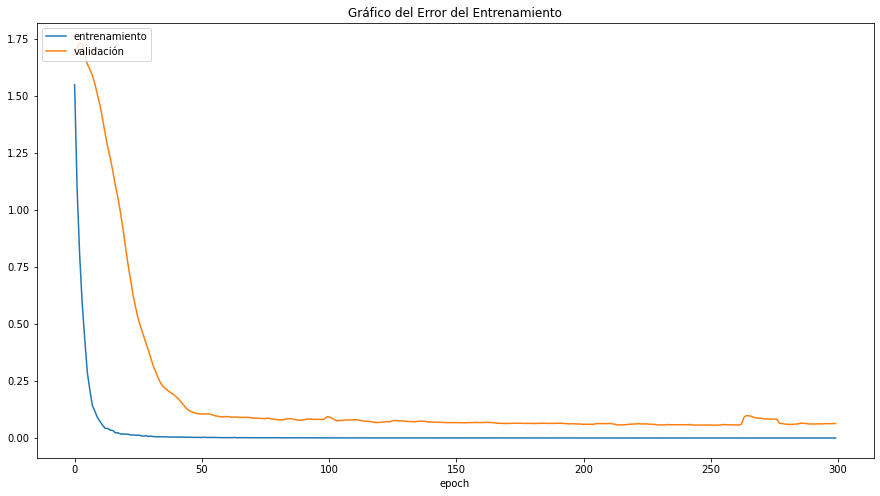

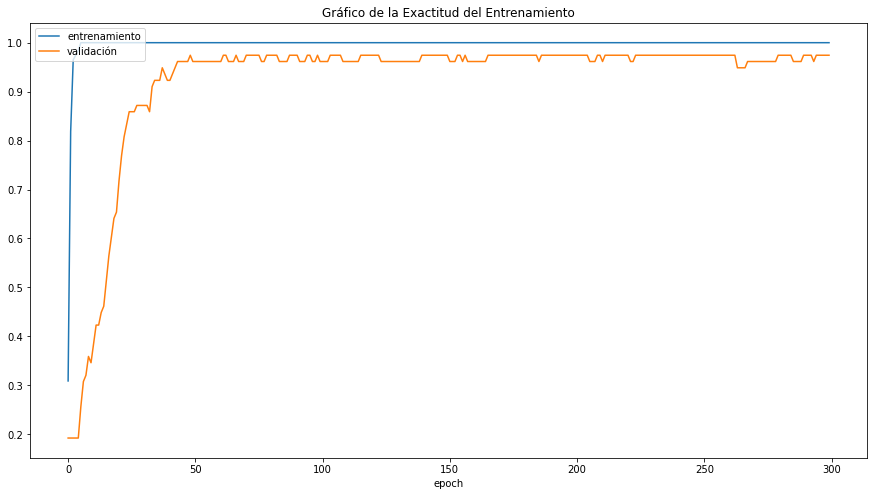

In [22]:
#@title Exportar Modelo y Re-Entrenar (opcional)

reentrenar_modelo = False #@param {type:"boolean"}

cant_epocas_reentrenamiento =  300#@param {type:"integer"}
if cant_epocas_reentrenamiento <= 0:
  cant_epocas_reentrenamiento = None


# exporta el modelo y lo muestra
print("\n>> Mejor modelo generado: ")
model = AKmodel.export_model()
model.summary()
print()
print("==================================\n")

tf.keras.utils.plot_model(
    model, to_file='RNA.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

from google.colab import files
try:
    model.save("model_autokeras", save_format="tf")
except Exception:
    model.save("model_autokeras.h5")

!tar -czvf model.tar.gz model_autokeras/

files.download('model.tar.gz')

if reentrenar_modelo: 
  # realiza el re-entrenamiento del modelo
  print("\n\n>Comienza el Re-Entrenamiento:")
  history = model.fit(train_ds,
          epochs=cant_epocas_reentrenamiento,
          verbose=1,
          validation_data=val_ds)
  
  print("\n>Re-Entrenamiento Finalizado.") 


#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

In [28]:
!tar -czvf model.tar.gz model_autokeras/
from google.colab import files

files.download('model.tar.gz')

model_autokeras/
model_autokeras/keras_metadata.pb
model_autokeras/assets/
model_autokeras/variables/
model_autokeras/variables/variables.index
model_autokeras/variables/variables.data-00000-of-00001
model_autokeras/saved_model.pb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
import matplotlib.pyplot as plt
import numpy as np

class Posicion():

  def __init__(self):
    self.x = 0
    self.y = 0

def avanzar(pos):
  pos.y += 5
  print('Avanzar coordenadas x:{0}, y:{1}'.format( pos.x,pos.y) )
  return pos

def frenar(pos):
  print('Frenar coordenadas x:{0}, y:{1}'.format( pos.x,pos.y) )
  return pos

def retroceder(pos):  
  pos.y -= 5
  print('Retroceder coordenadas x:{0}, y:{1}'.format( pos.x,pos.y) )
  return pos

def ir_izquierda(pos):  
  pos.x -= 5 
  print('Izquierda coordenadas x:{0}, y:{1}'.format( pos.x,pos.y) )
  return pos

def ir_derecha(pos): 
  pos.x += 5 
  print('Derecha coordenadas x:{0}, y:{1}'.format( pos.x,pos.y) )
  return pos

def mover(movimiento, posicion):
  if movimiento == 'avanzar':
    posicion = avanzar(posicion)
  elif movimiento == 'frenar':
    posicion = frenar(posicion)
  elif movimiento == 'retroceder':
    posicion = retroceder(posicion)
  elif movimiento == 'izquierda':
    posicion = ir_izquierda(posicion)
  elif movimiento == 'derecha':
    posicion = ir_derecha(posicion)

  plt.plot(posicion.x, posicion.y, marker="o", color="r")
  plt.show()

def config_grafico(movimiento):
  plt.title('Movimiento: ' + movimiento)

  plt.xlabel('X')
  plt.ylabel('Y')

  plt.grid()

  plt.axhline(0, color="black")
  plt.axvline(0, color="black")

  plt.xlim(-150, 150)
  plt.ylim(-150, 150)

def imprimirMovimiento(mov, pos):
  config_grafico(mov)
  mover(mov, pos)

#def main():
  #config_grafico()
#  pos = Posicion()
  #plt.plot(pos.x, pos.y, marker="o", color="r")
#  movimientos = ['Derecha','Derecha','Derecha','Avanzar','Avanzar','Izquierda','Izquierda','Retroceder','Izquierda','Frenar', 'Retroceder']

#  for mov in movimientos:
#    config_grafico(mov)
#    mover(mov, pos)

#main()

Test set accuracy: 93%

Reporte de clasificacion

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        20
           1       0.95      1.00      0.97        18
           2       1.00      0.95      0.97        20
           3       0.95      1.00      0.97        18
           4       0.94      0.80      0.86        20

    accuracy                           0.93        96
   macro avg       0.93      0.93      0.93        96
weighted avg       0.93      0.93      0.93        96

              p:avanzar  p:derecha  p:frenar  p:izquierda  p:retroceder
r:avanzar            18          1         0            1             0
r:derecha             0         18         0            0             0
r:frenar              0          0        19            0             1
r:izquierda           0          0         0           18             0
r:retroceder          4          0         0            0            16


Heatmap de confusion o matr

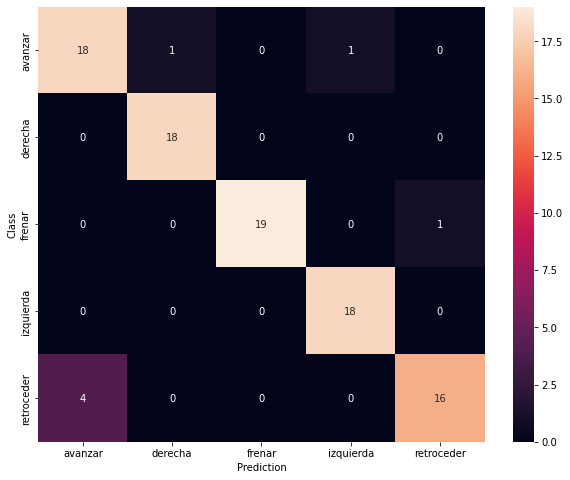

Predicciones de ejemplo
100 * np.max(prediction)  40.45886695384979
100 * np.max(prediction)  40.42052924633026
100 * np.max(prediction)  40.46057164669037
100 * np.max(prediction)  40.39252698421478
100 * np.max(prediction)  40.254345536231995
100 * np.max(prediction)  40.46017527580261
100 * np.max(prediction)  40.45223891735077
100 * np.max(prediction)  40.45417010784149
100 * np.max(prediction)  40.46088755130768
100 * np.max(prediction)  40.460214018821716
100 * np.max(prediction)  40.27129113674164
100 * np.max(prediction)  40.341874957084656
100 * np.max(prediction)  40.43012857437134
100 * np.max(prediction)  40.46085774898529
100 * np.max(prediction)  40.46041667461395
100 * np.max(prediction)  40.457454323768616
100 * np.max(prediction)  26.128289103507996
100 * np.max(prediction)  40.46006798744202
100 * np.max(prediction)  40.45153558254242
100 * np.max(prediction)  38.692376017570496
100 * np.max(prediction)  40.459948778152466
100 * np.max(prediction)  40.44782221317291
1

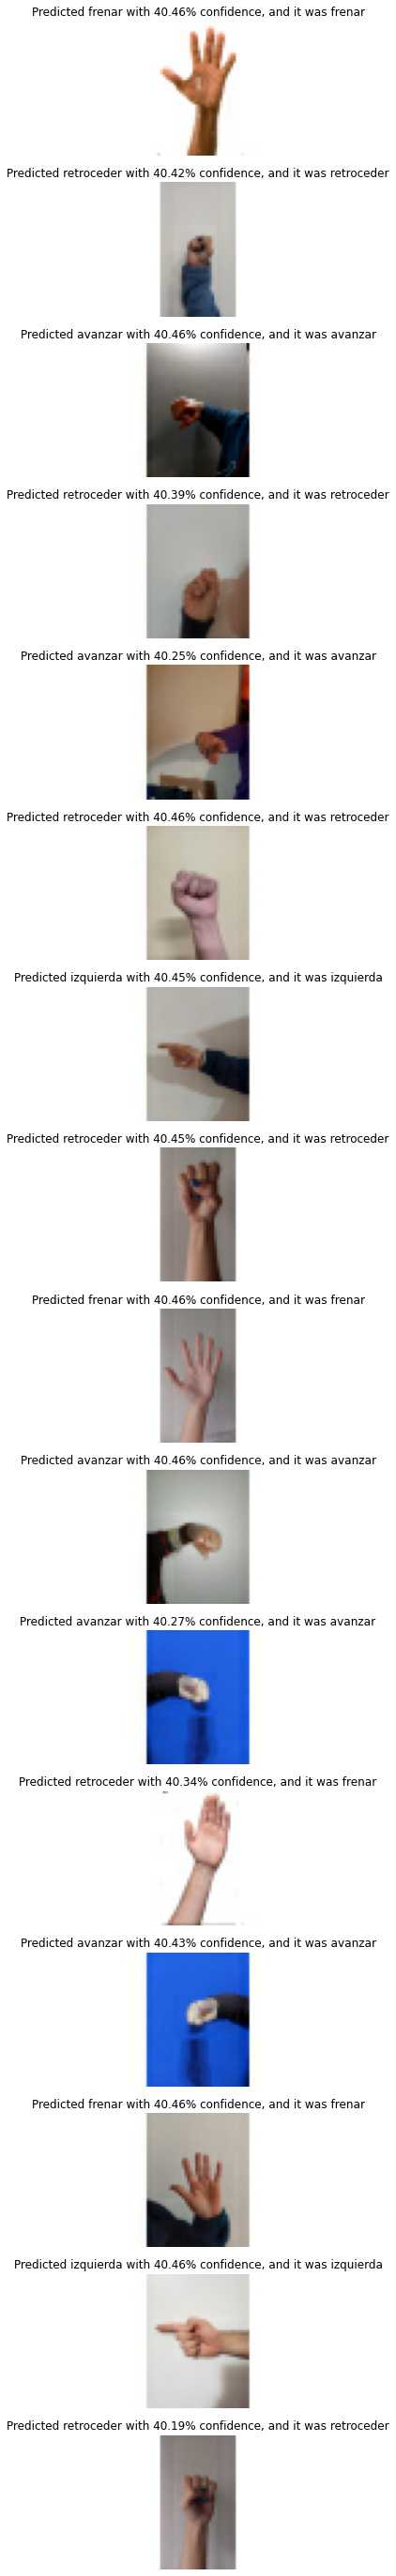

In [24]:
#@title Evaluar modelo contra test dataset

test_images_normal = []
test_images = []
test_images_classes = []

for image, label in test_ds:
  # for displaying purposes
  test_images_normal.append(image)
  test_images_classes.append(label.numpy())

predictions = model.predict(test_ds)

test_predict = np.argmax(predictions,axis=1)
flattened_real =[item for sublist in test_images_classes for item in sublist]
test_real = np.array(flattened_real)

test_acc = sum(1 if x == y else 0 for x, y in zip(test_predict.tolist(),test_real)) / len(test_real)                                       
print(f'Test set accuracy: {test_acc:.0%}\n')

#----
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mtx = tf.math.confusion_matrix(test_real, test_predict)

print("Reporte de clasificacion\n")
print(classification_report(flattened_real,test_predict))

test_real_labels = list(map(lambda x: class_names[x],test_real))
test_predict_labels = list(map(lambda x: class_names[x],test_predict.tolist()))

cm = confusion_matrix(test_real_labels,test_predict_labels,labels=class_names)
cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in class_names], 
        columns=['p:{:}'.format(x) for x in class_names]
      )
print(cmtx)
print("\n")


print("Heatmap de confusion o matriz\n")
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Class')
plt.show()

print("Predicciones de ejemplo")
plt.figure(figsize=(50, 50))
position = 0

#nuevo
#posicionActual = Posicion()   
movimientos=''
movimientosHacer=''
#print("len batch", len(batch))
for batch in test_images_normal:
  for image in batch:
    prediction = tf.nn.softmax(predictions[position])    
    label = flattened_real[position]    
    position = position + 1    
    
    if position <=len(batch):
      ax = plt.subplot(len(batch),1, position)
    
    #nuevo     
    movimientos = movimientos + class_names[np.argmax(prediction)]+','    

    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Predicted {} with {:.2f}% confidence, and it was {}"
               .format(class_names[np.argmax(prediction)],100 * np.max(prediction),class_names[label]))
    plt.axis("off")
    #nuevo   
    print("100 * np.max(prediction) ", 100 * np.max(prediction) )
    if 100 * np.max(prediction) > 70:
      movimientosHacer = movimientosHacer + class_names[np.argmax(prediction)]+','  

#print("movimientos", movimientos) 
    

In [25]:
print("Movimientos:", movimientos) 
print("Movimientos confiables a realizar", movimientosHacer)
print("array", movimientos.split(','))
#nuevo
posicionActual = Posicion()   

arrayTotal = movimientos.split(',')
array = movimientosHacer.split(',')
print("cantidad movimientos totales:", len(arrayTotal))
print("cantidad movimientos con porcentaje de acierto mayor al 40%:", len(array))

position=0
for mo in array:  
    position = position +1
    if position< len(array):
      imprimirMovimiento(array[position], posicionActual)



Movimientos: frenar,retroceder,avanzar,retroceder,avanzar,retroceder,izquierda,retroceder,frenar,avanzar,avanzar,retroceder,avanzar,frenar,izquierda,avanzar,derecha,avanzar,avanzar,avanzar,frenar,izquierda,retroceder,derecha,derecha,retroceder,izquierda,izquierda,frenar,frenar,derecha,frenar,avanzar,retroceder,derecha,retroceder,derecha,frenar,avanzar,derecha,derecha,izquierda,izquierda,retroceder,frenar,izquierda,derecha,izquierda,derecha,retroceder,avanzar,frenar,derecha,avanzar,avanzar,frenar,derecha,derecha,izquierda,frenar,izquierda,derecha,retroceder,avanzar,izquierda,frenar,izquierda,frenar,izquierda,frenar,avanzar,izquierda,frenar,avanzar,retroceder,derecha,izquierda,avanzar,izquierda,derecha,frenar,derecha,retroceder,avanzar,avanzar,avanzar,frenar,derecha,izquierda,frenar,derecha,retroceder,izquierda,retroceder,avanzar,retroceder,
Movimientos confiables a realizar 
array ['frenar', 'retroceder', 'avanzar', 'retroceder', 'avanzar', 'retroceder', 'izquierda', 'retroceder', 'fren